## VAE example
Follow the tutorial on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial which is for MNIST data; then adapt to CIFAR-10

In [2]:
import torch
import torch.nn as nn
import torch.distributions as dist

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from torch.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import time


In [3]:
dataset_path = '~/datasets'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load or download dataset

In [4]:
# options: MNIST, FashionMNIST, CIFAR10
data_set = "FashionMNIST"

In [5]:
batch_size = 1000 # NOTE: use 10000 for MNIST and FashionMNIST

if (data_set == "MNIST"):
    x_dim = 784
    hidden_dim = 400
    latent_dim = 200

if (data_set == "CIFAR10"):
    x_dim = 32 * 32 * 3  # 3 color channels...
    hidden_dim = 128
    latent_dim = 100


if (data_set == "FashionMNIST"):
    x_dim = 28 * 28
    # hidden_dim and latent_dim are specified later.


In [23]:
if (data_set == "MNIST"):
        from torchvision.datasets import MNIST
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader

        mnist_transform = transforms.Compose([
                transforms.ToTensor(),
        ])

        kwargs = {'num_workers': 1, 'pin_memory': True} 

        train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
        test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

if (data_set == "CIFAR10"):
        from torchvision.datasets import CIFAR10
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader


        mnist_transform = transforms.Compose([
                transforms.ToTensor(),
        ])

        kwargs = {'num_workers': 1, 'pin_memory': True} 

        train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
        test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)


if (data_set == "FashionMNIST"):
        from torchvision.datasets import FashionMNIST
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader


        mnist_transform = transforms.Compose([
                transforms.ToTensor(),
        ])

        kwargs = {'num_workers': 1, 'pin_memory': True} 

        train_dataset = FashionMNIST(dataset_path, transform=mnist_transform, train=True, download=True)
        test_dataset  = FashionMNIST(dataset_path, transform=mnist_transform, train=False, download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)


## Define target distribution and a variational family

In [6]:
use_bias = True
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim, bias = use_bias)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim, bias = use_bias)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim, bias = use_bias)
        self.FC_sd_log = nn.Linear(hidden_dim, latent_dim, bias = use_bias)

        self.LeakyRelu = nn.LeakyReLU(0.2)

        self.training = True  # CHECK -- what does this line do?

    def forward(self, x):
        h_ = self.LeakyRelu(self.FC_input(x))
        h_ = self.LeakyRelu(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        sd_log = self.FC_sd_log(h_)

        return mean, sd_log


In [7]:
def init_encoder(encoder, z_dim, hidden_dim, x_dim, nu_mean_z, nu_sd_z_log):
    # Initialize A-VI at the output of a constant inference network.
    encoder.FC_input.weights = nn.Parameter(torch.zeros(hidden_dim, x_dim)).to(device)
    encoder.FC_input2.weights = nn.Parameter(torch.zeros(hidden_dim, hidden_dim)).to(device)
    encoder.FC_mean.weights = nn.Parameter(torch.zeros(z_dim, hidden_dim)).to(device)
    encoder.FC_sd_log.weights = nn.Parameter(torch.zeros(z_dim, hidden_dim)).to(device)

    # encoder.FC_input.bias = nn.Parameter(torch.zeros(hidden_dim)).to(device)
    # encoder.FC_input2.bias = nn.Parameter(torch.zeros(hidden_dim)).to(device)
    encoder.FC_mean.bias = nn.Parameter(nu_mean_z)
    encoder.FC_sd_log.bias = nn.Parameter(nu_sd_z_log)

    return encoder


In [8]:
# NOTE: test what happens when we don't use a bias...
class Decoder_MNIST(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder_MNIST, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim, bias = False)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.FC_output = nn.Linear(hidden_dim, output_dim, bias = False)
        self.LeakyReLU = nn.LeakyReLU(0.2)

        # linear decoder
        # self.FC_output = nn.Linear(latent_dim, output_dim)

    def forward(self, z):
        h = self.LeakyReLU(self.FC_hidden(z))
        h = self.LeakyReLU(self.FC_hidden2(h))
        h = self.FC_output(h)

        # linear decoder
        # h = self.FC_output(z)

        x_hat = torch.sigmoid(h)

        return x_hat


In [9]:
use_bias = False  # NOTE: CHECKME!!

# NOTE: first attempt following what was done for MNIST
class Decoder_R(nn.Module):  # intended for a Beta likelihood
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder_R, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim, bias = use_bias)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim, bias = use_bias)
        self.FC_alpha = nn.Linear(hidden_dim, output_dim, bias = use_bias)
        # self.FC_beta = nn.Linear(hidden_dim, output_dim, bias = use_bias)
        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, z):
        h = self.LeakyReLU(self.FC_hidden(z))
        h = self.LeakyReLU(self.FC_hidden2(h))

        # NOTE: for Beta likelihood, we'll want to make alpha and beta positive
        # alpha = self.FC_alpha(h)**2
        # beta = self.FC_beta(h)**2

        # NOTE: hack, use constrained gaussian likelihood
        alpha = torch.sigmoid(self.FC_alpha(h))  # constrain mean between 0 and 1
        # beta = self.FC_beta(h)**2  # constrain variance to be positive

        return alpha  #, beta


In [10]:
def set_weights_MNIST(decoder, theta, latent_dim, hidden_dim, x_dim):
  with torch.no_grad():
    # linear decoder
    # decoder.FC_output.weight=\
    #   nn.Parameter(theta.reshape((x_dim, latent_dim)))
    
    ## Two-layers neural network

    # Set the weights
    index_layer1 = latent_dim * hidden_dim
    decoder.FC_hidden.weight =\
        nn.Parameter(theta[:index_layer1].reshape((hidden_dim, latent_dim)))
    
    index_layer2 = index_layer1 + hidden_dim**2
    decoder.FC_hidden2.weight =\
        nn.Parameter(theta[index_layer1:index_layer2].reshape((hidden_dim, hidden_dim)))
    
    index_output = index_layer2 + hidden_dim * x_dim
    decoder.FC_output.weight =\
            nn.Parameter(theta[index_layer2:index_output].reshape((x_dim, hidden_dim)))
    
    # Set the biases
    # index_bias1 = index_output + hidden_dim
    # decoder.FC_hidden.bias =\
    #   nn.Parameter(torch.zeros(hidden_dim)).to(device)
    #   # nn.Parameter(theta[index_output:index_bias1].reshape((hidden_dim)))
    
    # index_bias2 = index_bias1 + hidden_dim
    # decoder.FC_hidden2.bias =\
    #   nn.Parameter(torch.zeros(hidden_dim)).to(device)
    #   # nn.Parameter(theta[index_bias1:index_bias2].reshape((hidden_dim)))

    # index_bias3 = index_bias2 + x_dim
    # decoder.FC_output.bias =\
    #   nn.Parameter(torch.zeros(x_dim)).to(device)
      # nn.Parameter(theta[index_bias2:index_bias3].reshape((x_dim)))  

    return decoder


def set_weights_R(decoder, theta, latent_dim, hidden_dim, x_dim):
    # Set the weights
    index_layer1 = latent_dim * hidden_dim
    decoder.FC_hidden.weight =\
        nn.Parameter(theta[:index_layer1].reshape((hidden_dim, latent_dim)))
    
    index_layer2 = index_layer1 + hidden_dim**2
    decoder.FC_hidden2.weight =\
        nn.Parameter(theta[index_layer1:index_layer2].reshape((hidden_dim, hidden_dim)))
    
    index_alpha = index_layer2 + hidden_dim * x_dim
    decoder.FC_alpha.weight =\
            nn.Parameter(theta[index_layer2:index_alpha].reshape((x_dim, hidden_dim)))
    
    # NOTE: to mimic MSE, beta parameter (standard deviation) is set to 1
    # index_beta = index_alpha + hidden_dim * x_dim
    # decoder.FC_beta.weight =\
    #     nn.Parameter(theta[index_alpha:index_beta].reshape((x_dim, hidden_dim)))
    
    return decoder
    

In [11]:
# NOTE: pytorch distributions don't seem to work cudas
def bernoulli_lpmf(x, p):
    eps = 1e-10
    return torch.sum(x * torch.log(p + eps) + (1 - x) * torch.log(1 - p + eps),
                                  dim = (1, 2))

def gaussian_lpdf(x, mu, sigma_2):
    return torch.sum( - 0.5 * torch.log(sigma_2) - 1 / (2 * sigma_2) * (x - mu)**2,
                     dim = (1, 2))

# NOTE: lgamma doesn't work on CUDA. Once this is fixed better to use Torch.distributions.
def beta_lpdf(x, alpha, beta):
    iid_components = torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta)\
        + (alpha - 1) * torch.log(x) + (beta - 1) * torch.log(1 - x)
    return torch.sum(iid_components, dim = (1, 2))


In [12]:
# vectorized for GPU (the first index corresponds to the Monte Carlo sample)
# the log_joint is computed over a batch of the data, rather than over the full data.
def log_joint_MNIST(x, p, z, theta):
    eps = 1e-10  # add jitter to stabilize cases where p is close to 0 or 1
    like_weight = z.size()[1] / x.size()[0]
    
    return -0.5 * torch.sum(z**2, dim = (1, 2))\
           -0.5 * torch.sum(theta**2, dim = 1)\
        + like_weight * bernoulli_lpmf(x, p)

def log_joint_R(x, alpha, beta, z, theta):
    like_weight = z.size()[1] / x.size()[0]
    # beta_dist = dist.beta.Beta(alpha, beta)
    return -0.5 * torch.sum(z**2, dim = (1, 2))\
           -0.5 * torch.sum(theta**2, dim = 1)\
            + like_weight * gaussian_lpdf(x, alpha, beta)
        # + like_weight *  torch.sum(beta_dist.log_prob(x), dim = (1, 2))
        # + like_weight * gaussian_lpdf(x, alpha, beta)
        # + like_weight * beta_lpdf(x, alpha, beta)
        

def log_q(theta, z, nu_mean_theta, nu_sd_theta_2, nu_mean_z, nu_sd_z_2):
  log_q_theta = torch.sum(- 0.5 * torch.log(nu_sd_theta_2) - 1 / (2 * nu_sd_theta_2)\
                          * (theta - nu_mean_theta)**2, dim = (1))  # CHECK -- axis along which to sum
  log_q_z = torch.sum(- 0.5 * torch.log(nu_sd_z_2) - 1 / (2 * nu_sd_z_2)\
                      * (z - nu_mean_z)**2, dim = (1, 2))
  return log_q_theta + log_q_z


In [13]:
class Model(nn.Module):
    def __init__(self, x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = 0,
                 const_z = False, mc_samples = 100,
                 init_z = False, nu_mean_z_init = torch.empty(0), nu_sd_z_log_init = torch.empty(0),
                 init_theta = False, nu_mean_theta_init = torch.empty(0),
                 nu_sd_theta_log_init = torch.empty(0),
                 use_init_encoder = False):
        # NOTE: when using init_z = True, nu_mean_z_init and nu_sd_z_log_init must have
        # dimension n_obs * z_dim. When using init_encoder = False, the inits for z should
        # have dimension z_dim.

        super(Model, self).__init__()

        self.use_avi = use_avi
        self.const_z = const_z

        self.x_dim = x_dim
        self.z_dim = z_dim
        self.n_obs = n_obs
        self.hidden_dim = hidden_dim
        self.like_dim = like_dim

        if (data_set == "MNIST"):
            # size of weights
            self.dim_theta = z_dim * like_dim + like_dim**2 + like_dim * x_dim
        if (data_set == "CIFAR10" or data_set == "FashionMNIST"):
            self.dim_theta = z_dim * like_dim + like_dim**2 + like_dim * x_dim

        # variational parameters for q(theta)
        if (init_theta):
            self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init)
            self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init)
        else:
            self.nu_mean_theta = torch.nn.Parameter(torch.zeros(self.dim_theta))
            self.nu_sd_theta_log = torch.nn.Parameter(torch.zeros(self.dim_theta) - 2)

        # variational parameters for q(z)
        if (const_z and (not use_avi)):
            self.nu_mean_z = torch.nn.Parameter(torch.randn(z_dim))
            self.nu_sd_z_log = torch.nn.Parameter(torch.randn(z_dim))
        elif (use_avi):
            if (use_init_encoder):
                self.Encoder = init_encoder(Encoder(x_dim, hidden_dim, z_dim),
                                            z_dim, hidden_dim, x_dim,
                                            nu_mean_z_init, nu_sd_z_log_init)

            self.Encoder = Encoder(x_dim, hidden_dim, z_dim)
        else:
            if (init_z):
                self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init)
                self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init)
            else:
                self.nu_mean_z = torch.nn.Parameter(torch.randn(n_obs, z_dim))
                self.nu_sd_z_log = torch.nn.Parameter(torch.randn(n_obs, z_dim) - 1)
        
        self.mc_samples = mc_samples
        
    def reparam(self, nu_mean_z, nu_sd_z, nu_mean_theta, nu_sd_theta, mc_samples):
        epsilon = torch.randn((mc_samples, self.n_obs, self.z_dim)).to(device)
        z = nu_mean_z + nu_sd_z * epsilon
        
        epsilon_theta = torch.randn((mc_samples, self.dim_theta)).to(device)
        theta = nu_mean_theta + nu_sd_theta * epsilon_theta

        return z, theta
    
    def variational_z(self, x):
        if (self.use_avi):
            nu_mean_z, nu_sd_z_log = self.Encoder(x)
        elif (self.const_z):
            nu_mean_z = self.nu_mean_z.repeat((self.n_obs, 1))
            nu_sd_z_log = self.nu_sd_z_log.repeat((self.n_obs, 1))
        else:
            nu_mean_z = self.nu_mean_z
            nu_sd_z_log = self.nu_sd_z_log
        
        return nu_mean_z, nu_sd_z_log
    
    def compute_elbo(self, x, batch_index, batch_size):
        nu_mean_z, nu_sd_z_log = self.variational_z(x)

        z, theta = self.reparam(nu_mean_z, torch.exp(nu_sd_z_log),
                                self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                                self.mc_samples)

        # only compute p for the z's relevant to the current batch
        z_batch = z[:, (batch_index * batch_size):((batch_index + 1) * batch_size), :]

        if (data_set == "MNIST"):
            decoder = Decoder_MNIST(self.z_dim, self.like_dim, self.x_dim).to(device)
            p = torch.empty((self.mc_samples, batch_size, self.x_dim)).to(device)

            for i in range(self.mc_samples): 
                decoder = set_weights_MNIST(decoder, theta[i,:], self.z_dim, self.like_dim,
                                            self.x_dim)
                p[i, :, :] = decoder.forward(z_batch[i, :, :])
        
            Elbo = log_joint_MNIST(x, p, z_batch, theta)
        
        if (data_set == "CIFAR10" or data_set == "FashionMNIST"):
            decoder = Decoder_R(self.z_dim, self.like_dim, self.x_dim).to(device)
            alpha = torch.empty((self.mc_samples, batch_size, self.x_dim)).to(device)
            beta = torch.empty((self.mc_samples, batch_size, self.x_dim)).to(device)

            for i in range(self.mc_samples):
                decoder = set_weights_R(decoder, theta[i,:], self.z_dim, self.like_dim, self.x_dim)
                alpha[i, :, :] = decoder.forward(z_batch[i, :, :])
            
            beta = torch.ones((self.mc_samples, batch_size, self.x_dim)).to(device)
            Elbo = log_joint_R(x, alpha, beta, z_batch, theta)
            
        Elbo = Elbo - log_q(theta, z_batch, self.nu_mean_theta, torch.square(self.nu_sd_theta_log),
                    nu_mean_z, torch.square(nu_sd_z_log))

        return torch.mean(Elbo)
    
    def variational_parameters(self, x):
        nu_mean_z, nu_sd_z_log = self.variational_z(x)
        return self.nu_mean_theta, self.nu_sd_theta_log, nu_mean_z, nu_sd_z_log


## Full Bayesian inference using VI

In [14]:
# For starters, let's use a relatively small network
if (data_set == "MNIST"):
    x_dim = 784
    z_dim = 20  # 200
    hidden_dim = 20  # 400
    like_dim = 40  # 400
    n_obs = batch_size  # NOTE: if using only a subsample, set to batchsize (rather than total n_obs)
    n_epochs = 4000 # 1000  # 30

if (data_set == "CIFAR10" or data_set == "FashionMNIST"):
    z_dim = 20
    hidden_dim = 20
    like_dim = 40
    n_obs = 60000
    batch_size = batch_size
    n_epochs = 100

if (data_set == "CIFAR10"):
    x_dim = 32 * 32 * 3
elif (data_set == "FashionMNIST"):
    x_dim = 28 * 28


In [15]:
# Use a subset of the data (i.e. get the first batch and save it as x)
for batch_idx, (x, _) in enumerate(train_loader):
    x = x.view(batch_size, x_dim)
    x = x.to(device)
    break

n_obs = batch_size  # for experiment adjust batch size


In [16]:
def fvi_diagnose(model, mc_samples = 100):
    nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log = model.variational_parameters(x)

    model_benchmark = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False, hidden_dim = 0,
                            const_z = False, mc_samples = mc_samples,
                            init_z = True, nu_mean_z_init = nu_mean_z, nu_sd_z_log_init = nu_sd_z_log,
                            init_theta = True, nu_mean_theta_init = nu_mean_theta,
                            nu_sd_theta_log_init = nu_sd_theta_log).to(device)

    loss = - model_benchmark.compute_elbo(x, batch_idx, batch_size)
    loss.backward()

    grads = []
    for param in model_benchmark.parameters():
        grads.append(param.grad.view(-1) / loss)
    grads = torch.cat(grads)

    return torch.norm(grads)


In [17]:
def run_vi(seed, model, n_epochs, print_output = False, lr = 1e-3):
    # Run VI, given a seed and a model, for a specified number of iterations.
    # The optimization is divided into three phases of equal length. At the
    # beginning of each phase, the learning rate decreases by a factor of 0.1.
    #
    torch.manual_seed(seed)
    optimizer = Adam(model.parameters(), lr = lr)

    n_phase = n_epochs // 3

    if (print_output):
        print("Starting training VAE...")
    model.train()  # CHECK -- is this helpful?
    loss_saved = np.empty(n_epochs)
    index_saved = 0

    start_time = time.time()
    for i in range(n_epochs):
        optimizer.zero_grad()
        loss = - model.compute_elbo(x, batch_idx, batch_size)

        loss_saved[index_saved] = loss.data
        index_saved +=1 

        loss.backward()
        optimizer.step()

        if ((n_epochs % n_phase == 0) and (n_epochs != 0)):
            lr = lr * 0.1

        if (print_output and (i % 10 == 0)):
            print("\titeration:", i, "\tloss: ", loss.data)

            grads = []
            for param in model.parameters():
                grads.append(param.grad.view(-1) / loss)
            grads = torch.cat(grads)
            print("\tGradient norm = ", torch.max(grads).data)

    end_time = time.time()
    run_time = end_time - start_time

    fvi_grad = fvi_diagnose(model) 
   
    return model, loss_saved, run_time, fvi_grad

In [20]:
seed = 1954
lr = 1e-4
n_epochs = 100

### Individual runs
(This is useful for debugging but not required to get experimental results, which are run in a more systematic way.)

In [32]:
run_individual = False

In [25]:
if (run_individual):
    torch.manual_seed(1954)
    model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False, hidden_dim = 0,
                mc_samples = 100).to(device)
    model, loss_saved, run_time, fvi_grad = run_vi(seed, model, n_epochs, print_output = True, lr = lr)

    plt.plot(-loss_saved)
    plt.yscale("log")
    print(model.nu_mean_z)
    print(model.nu_sd_z_log)

In [26]:
if (run_individual):
    # Run F-VI again, this time using a different seed
    torch.manual_seed(1989)
    model2 = Model(x_dim, z_dim, hidden_dim, n_obs, like_dim, use_avi = False,
                mc_samples = 100).to(device)
    model2, loss_saved2 = run_vi(seed, model2, n_epochs, print_output = True, lr = lr)


In [27]:
if (run_individual):
    torch.manual_seed(seed)
    hidden_dim = 40  # 20
    model_avi = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = hidden_dim,
                mc_samples = 100).to(device)
    model_avi, loss_avi_saved, run_time, fvi_grad =\
        run_vi(seed, model_avi, n_epochs, print_output = True, lr = lr)


In [28]:
if (run_individual):
    torch.manual_seed(seed)
    hidden_dim = 1
    model_avi2 = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim=hidden_dim,
                mc_samples = 100).to(device)
    model_avi2, loss_avi2_saved, time_saved, fg_saved =\
        run_vi(seed, model_avi2, n_epochs, print_output = True, lr = lr)


In [29]:
if (run_individual):
    torch.manual_seed(seed)
    hidden_dim = 10
    model_avi3 = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = hidden_dim,
                mc_samples = 100).to(device)
    model_avi3, loss_avi3_saved, _, _ = run_vi(seed, model_avi3, n_epochs, print_output = True, lr = lr)


In [31]:
if (run_individual):
    torch.manual_seed(seed)
    hidden_dim = 15
    model_avi4 = Model(x_dim, z_dim, hidden_dim, n_obs, like_dim, use_avi = True,
                mc_samples = 100).to(device)
    model_avi4, loss_avi4_saved = run_vi(seed, model_avi4, n_epochs, print_output = True)

In [33]:
if (run_individual):
    torch.manual_seed(seed)
    hidden_dim = 100 # 60
    model_avi5 = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True, hidden_dim = hidden_dim,
                mc_samples = 100).to(device)
    model_avi5, loss_avi5_saved, _, _ =\
        run_vi(seed, model_avi5, n_epochs, print_output = True, lr = lr)


In [34]:
if (run_individual):
    nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log = model_avi2.variational_parameters()
    model_init = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False, mc_samples = 100,
                    init_z = True, nu_mean_z_init = nu_mean_z,
                    nu_sd_z_log_init = nu_sd_z_log,
                    init_theta = True, nu_mean_theta_init = nu_mean_theta,
                    nu_sd_theta_log_init = nu_sd_theta_log).to(device)

    model_init, loss_init_saved, time_saved, fg_grad =\
        run_vi(seed, model_init, n_epochs, print_output = True, lr = lr)


In [35]:
if (run_individual):
    torch.manual_seed(seed)
    model_const = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False,
                        const_z = True, mc_samples = 100).to(device)
    model_const, loss_const_saved, _, _ =\
        run_vi(seed, model_const, n_epochs, print_output = True, lr = lr)


In [36]:
if (run_individual):
    nu_mean_z = model_const.nu_mean_z
    nu_sd_z_log = model_const.nu_sd_z_log

    torch.manual_seed(seed)
    lr = 1e-5
    hidden_dim = 100 # 60
    model_avi_init = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True,
                    hidden_dim = hidden_dim, mc_samples=100,
                    use_init_encoder = True,
                    nu_mean_z_init = nu_mean_z,
                    nu_sd_z_log_init = nu_sd_z_log).to(device)
    model_avi_init, loss_avi_init_saved, _, _ =\
        run_vi(seed, model_avi_init, n_epochs, print_output = True, lr = lr)


In [37]:
if (run_individual):
    n_start = 0
    n_end = n_epochs
    base = 0
    plt.plot(- loss_saved[n_start:n_end] + base, label = 'F-VI', color = "black")
    # plt.plot(loss_saved2[n_start:n_epochs] + base, label = 'F-VI2', alpha = 0.5)
    plt.plot(- loss_avi2_saved[n_start:n_end] + base, label = 'k = 1', alpha = 0.5)
    plt.plot(- loss_avi3_saved[n_start:n_end] + base, label = 'k = 10', alpha = 0.5)
    #plt.plot(loss_avi4_saved[n_start:n_end] + base, label = 'k = 15', alpha = 0.5)
    plt.plot(- loss_avi_saved[n_start:n_end] + base, label = 'k = 40', alpha = 0.5)
    plt.plot(- loss_avi5_saved[n_start:n_end] + base, label = 'k = 100', alpha = 0.5)
    # plt.plot(- loss_init_saved[n_start:n_end] + base, label = 'F-VI (init)', alpha = 0.5)
    plt.plot(- loss_const_saved[n_start:n_end] + base, label = 'Const', color = "red")
    # plt.plot(- loss_avi_init_saved[n_start:n_end] + base, label = "k = 100 (init)", alpha = 0.5)
    plt.yscale("log")
    plt.legend(loc = "best")


## Run numerical experiments

In [18]:
def run_experiment(seed, data_set, n_epochs, nn_widths, lr):
    # NOTE: the seed is used (i) when initializing the model, and (ii) when running the
    # optimizer.

    loss_all = np.empty((n_epochs, 3 + nn_widths.size))
    saved_times = np.empty(3 + nn_widths.size)
    saved_fvi_gradient = np.empty(3 + nn_widths.size)

    # Run F-VI
    torch.manual_seed(seed)
    model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False).to(device)
    _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output = False, lr = lr)
    loss_all[:, 0] = loss
    saved_times[0] = time_s
    saved_fvi_gradient[0] = fvi_gradient.data

    # Run A-VI
    for i in range(nn_widths.size):
        print("\tRunning widths = ", nn_widths[i])
        torch.manual_seed(seed)
        model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = True,
                      hidden_dim = nn_widths[i]).to(device)
        _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output = False, lr = lr)
        loss_all[:, i + 1] = loss
        saved_times[i + 1] = time_s
        saved_fvi_gradient[i + 1] = fvi_gradient.data

        if (i == 0):
            best_loss = loss_all[n_epochs - 1, i + 1]
            model_best = _model
        elif (loss_all[n_epochs - 1, i + 1] <= best_loss):
            best_loss = loss_all[n_epochs - 1, i + 1]
            model_best = _model
    
    # Run F-VI with an initialization provided by A-VI (k = 100)
    nu_mean_theta, nu_sd_theta_log, nu_mean_z, nu_sd_z_log = model_best.variational_parameters(x)
    model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False,
                  init_z = True, nu_mean_z_init = nu_mean_z,
                  nu_sd_z_log_init = nu_sd_z_log,
                  init_theta = True, nu_mean_theta_init = nu_mean_theta,
                  nu_sd_theta_log_init = nu_sd_theta_log).to(device)
    _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output = False, lr = lr)
    loss_all[:, nn_widths.size + 1] = loss
    saved_times[nn_widths.size + 1] = time_s
    saved_fvi_gradient[nn_widths.size + 1] = fvi_gradient.data

    # Run A-VI with constant out for inference network
    model = Model(x_dim, z_dim, like_dim, n_obs, use_avi = False, const_z = True).to(device)
    _model, loss, time_s, fvi_gradient = run_vi(seed, model, n_epochs, print_output=False, lr=lr)
    loss_all[:, nn_widths.size + 2] = loss
    saved_times[nn_widths.size + 2] = time_s
    saved_fvi_gradient[nn_widths.size + 2] = fvi_gradient.data

    np.save("deliv/vae_" + data_set + "_loss_" + str(seed), loss_all)
    np.save("deliv/vae_" + data_set + "_time_" + str(seed), saved_times)
    np.save("deliv/fvi_" + data_set + "_gradient_" + str(seed), saved_times)


In [19]:
# nn_widths = np.array([1, 10, 40, 80, 100, 120])
nn_widths = np.array([1, 10, 20, 40, 80, 120])
n_epochs = 500  # 2000 (1000 might be enough)
# lr = 1e-5

# run_experiment(seed, data_set, n_epochs, nn_widths, lr)


In [20]:
lr = 1e-4  # for A-VI on CIFAR10, may require a smaller learning rate.
init_seed = 1954
for i in range(10):
    seed = init_seed + i
    print("seed: ", seed)
    run_experiment(seed, data_set, n_epochs, nn_widths, lr)

seed:  1954
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1955
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1956
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1957
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1958
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1959
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths =  120
seed:  1960
	Running widths =  1
	Running widths =  10
	Running widths =  20
	Running widths =  40
	Running widths =  80
	Running widths

## Read in and analyze experimental results

In [39]:
n_epochs = 500
nn_widths = np.array([1, 10, 20, 40, 80, 120])

In [40]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)])

window = 10
index_center = n_epochs - window

In [41]:
# Get results across multiple seeds
# For FashionMNIST, init_seed is 1789
# For MNIST, init_seed is 1954
# For CIFAR10, init_seed is 1963

data_set = "FashionMNIST"
init_seed = 1789
num_seed = 10
num_algorithms = nn_widths.size + 3
n_epochs = 500

Elbo_final = np.empty((num_seed, num_algorithms))

for i in range(num_seed):
    loss_all = np.load("deliv/vae_" + data_set + "_loss_" + str(init_seed + i) + ".npy")

    for j in range(num_algorithms):
        Elbo_final[i, j] = mean_window(loss_all[:,j], n_epochs - window, window)

# Get the best (non-nan) Elbo estimate obtained with 
Elbo_silver = - np.nanmin(Elbo_final[:, nn_widths.size + 1])

# Get the optimal Elbo returned by all algorithms
Elbo_max = - np.nanmin(Elbo_final, axis = 0)
print("Elbo max: ", Elbo_max)

print("Elbo silver: ", Elbo_silver)


Elbo max:  [5.04399973e+17 1.01117661e+18 6.02057902e+17 2.94839370e+18
 4.15585126e+18 9.22298583e+18 6.64609740e+18 1.98181110e+19
 9.65803873e+14]
Elbo silver:  1.9818110995989213e+19


In [42]:
plt.style.use('seaborn-white')  # seaborn-v0_8-white

params = {'axes.labelsize': 18,'axes.titlesize':25, 'legend.fontsize': 15, 'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

linewidth = 2


/tmp/ipykernel_3493474/1543660394.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')  # seaborn-v0_8-white


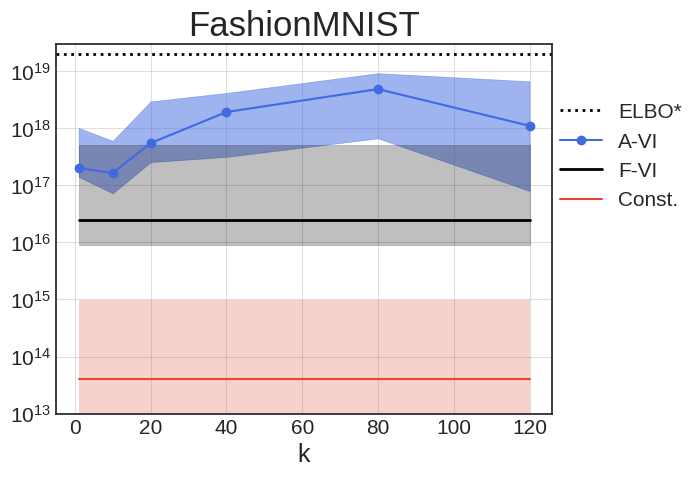

In [43]:
Elbo_median = - np.nanmedian(Elbo_final, axis = 0)
Elbo_min = - np.nanmax(Elbo_final, axis = 0)

linewidth = 2

plt.axhline(y = Elbo_silver, linewidth = linewidth, color = 'black', linestyle = "dotted",
           label = "ELBO*")

plt.plot(nn_widths, Elbo_median[1:7], "-o", label = "A-VI", color = "royalblue")
plt.fill_between(nn_widths, Elbo_max[1:7], Elbo_min[1:7], alpha = 0.5, color = "royalblue")

plt.plot(nn_widths, np.repeat(Elbo_median[0], 6), linewidth = linewidth, color = 'black', label = "F-VI")
plt.fill_between(nn_widths, np.repeat(Elbo_min[0], 6), np.repeat(Elbo_max[0], 6), alpha = 0.25,
                 color = "black")

plot_constant = True

if(plot_constant):
    plt.plot(nn_widths, np.repeat(Elbo_median[8], 6), label = "Const.")
    plt.fill_between(nn_widths, Elbo_max[8], Elbo_min[8], alpha = 0.25)

plt.yscale("log")
plt.grid(which = 'major', visible = 'true', c = 'grey', alpha = 0.25)
plt.xlabel("k")
if (data_set == "MNIST"):
    plt.ylabel("ELBO")
plt.title(data_set)
if (data_set == "FashionMNIST"):
    plt.legend(loc = "lower right", bbox_to_anchor=(1.3, 0.5))
    plt.ylim(1e13, 3e19)


plt.savefig("to_discuss/k_vae_" + data_set + ".pdf", bbox_inches = 'tight')


In [44]:
# Examine a specific seed for example plot
seed = 1968
data_set = "CIFAR10"  # Options: MNIST, FashionMNIST
loss_all = np.load("deliv/vae_" + data_set + "_loss_" + str(seed) + ".npy")


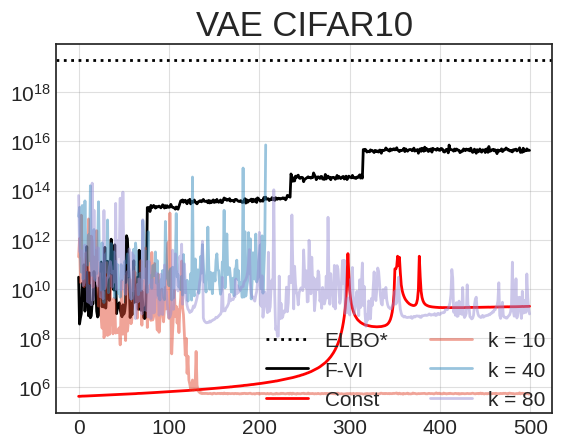

In [45]:

fig, ax = plt.subplots()
plotted_widths = np.array([10, 40, 80])
# nn_widths = np.array([1, 10, 20, 40, 80, 120])

n_start = 0

# ax.plot(- loss_all[n_start:, nn_widths.size + 1], label = "AF-VI", color = 'black',
#         linestyle = "dashed", linewidth = linewidth)

ax.axhline(y = Elbo_silver, linewidth = linewidth, color = 'black', linestyle = "dotted",
           label = "ELBO*")

ax.plot(-loss_all[n_start:, 0], label = 'F-VI', linewidth = linewidth, color = 'black')


ax.plot(-loss_all[n_start:, nn_widths.size + 2], label = "Const", color = "red",
        linewidth = linewidth)

nn_widths = np.array([1, 10, 20, 40, 80, 120])
for i in range(nn_widths.size):
    if (nn_widths[i] in plotted_widths):
        ax.plot(- loss_all[n_start:, i + 1], label = "k = " + str(nn_widths[i]), alpha = 0.5,
        linewidth = linewidth)

plt.grid(which = 'major', visible = 'true', c = 'grey', alpha = 0.25)
plt.legend(loc = "lower right", ncols = 2, bbox_to_anchor=(1.025, -0.04))
# plt.ylim(10**1, 1 * 10**19)
plt.yscale("log")
plt.title("VAE " + data_set)

plt.savefig("to_discuss/elbo_vae_" + data_set + "_" + str(seed) + ".pdf", bbox_inches = 'tight')
plt.show()


In [97]:
# Get asymptotic ELBO
print("Silver: ", mean_window(loss_all[:, nn_widths.size + 1], index_center, window), " +/- ",
      sd_window(loss_all[:, nn_widths.size + 1], index_center, window))

print("FVI: ", mean_window(loss_all[:, 0], index_center, window), " +/- ",
      sd_window(loss_all[:, 0], index_center, window))

print("Const: ", mean_window(loss_all[:, nn_widths.size + 2], index_center, window), " +/- ",
      sd_window(loss_all[:, nn_widths.size + 2], index_center, window))

for i in range(nn_widths.size):
  print("k = " + str(nn_widths[i]) + ": ", mean_window(loss_all[:, i + 1],
        index_center, window), " +/- ",
        sd_window(loss_all[:, i], index_center, window))


Silver:  -1.916481070865192e+19  +/-  1.3551668232630513e+18
FVI:  -1.4343688474979206e+16  +/-  8321339449737356.0
Const:  -965815298403860.5  +/-  1389057317300.9983
k = 1:  -4.4422675871549094e+17  +/-  8321339449737356.0
k = 10:  -1.736477394706891e+17  +/-  3.778198812129833e+16
k = 20:  -2.6109344666148144e+17  +/-  1.921753083796226e+16
k = 40:  -8.440083323917487e+17  +/-  3.859208973807375e+16
k = 80:  -7.530952081576905e+18  +/-  7.869393942158878e+16
k = 120:  -6.128665710349181e+18  +/-  1.0217704987858893e+18
